<a href="https://colab.research.google.com/github/KFurudate/RStanBook/blob/main/Chapter_10_1_4_multinomial_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 多項ロジスティック回帰

目的：どのような年齢・性別・年収の人がどのカテゴリーを選びやすかを知ること

In [1]:
DAY="20201217"

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls drive/MyDrive/RStanBook_アヒル本/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Chapter 10_1_4_multinomial_logistic_regression.ipynb'
 input
 output
 RStanBook-master
'StanとRでベイズ統計モデリング Wonderful R 2 松浦 健太郎 282p_B07M8LWLS1.pdf'


In [3]:
!chmod -R 777 drive/MyDrive/RStanBook_アヒル本/input
!ls -all drive/MyDrive/RStanBook_アヒル本/input

total 147
-rwx------ 1 root root   921 May 10  2020 d1.csv
-rwx------ 1 root root  1116 May 10  2020 data-2Dmesh-design.txt
-rwx------ 1 root root  1908 May 10  2020 data-2Dmesh.txt
-rwx------ 1 root root   979 May 10  2020 data3a.csv
-rwx------ 1 root root  1145 May 10  2020 data4a.csv
-rwx------ 1 root root   816 May 10  2020 data-50m.txt
-rwx------ 1 root root   497 May 10  2020 data7a.csv
-rwx------ 1 root root  1680 May 10  2020 data-aircon.txt
-rwx------ 1 root root   593 May 10  2020 data-attendance-1.txt
-rwx------ 1 root root   751 May 10  2020 data-attendance-2.txt
-rwx------ 1 root root 30253 May 10  2020 data-attendance-3.txt
-rwx------ 1 root root   447 May 10  2020 data-attendance-4-1.txt
-rwx------ 1 root root 21347 May 10  2020 data-attendance-4-2.txt
-rwx------ 1 root root  1114 May 10  2020 data-attendance-5.txt
-rwx------ 1 root root  3317 May 10  2020 data-category.txt
-rwx------ 1 root root  3614 May 10  2020 data-changepoint.txt
-rwx------ 1 root root   202 May 10

In [4]:
!wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh && bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local
!conda update conda -y -
!source /usr/local/etc/profile.d/conda.sh
!conda init

--2020-12-18 01:58:37--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-12-18 01:58:37--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94235922 (90M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh.3’

Miniconda3-latest-L 100%[===================>]  89.87M   159MB/s    in 0.6s    

2020-12-18 01:58:37 (159 MB/s) - ‘Miniconda3-latest-Lin

In [5]:
conda_envs = !conda env list
res = [i for i in conda_envs if 'test36' in i]
if (len(res) == 0):
    print('not found test36 env', len(res))
    !conda create -y -q --name test36 python=3.7
else:
    print('found test36 env', len(res))

found test36 env 1


In [6]:
%%bash
source activate test36

python
import sys
# maybe only need this the first time we run this notebook
sys.path.append('/usr/local/lib/python3.7/site-packages')

print("Python version")
print(sys.version)

Python version
3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]


In [7]:
!conda config --add channels http://conda.anaconda.org/dranew
!conda config --add channels http://conda.anaconda.org/shahcompbio
!conda config --append channels conda-forge

In [8]:
#!conda install pymc3 
pip install git+https://github.com/pymc-devs/pymc3

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pymc3


The following packages will be UPDATED:

  ca-certificates                              2020.10.14-0 --> 2020.12.8-h06a4308_0
  certifi            pkgs/main/noarch::certifi-2020.6.20-p~ --> pkgs/main/linux-64::certifi-2020.12.5-py38h06a4308_0
  openssl                                 1.1.1h-h7b6447c_0 --> 1.1.1i-h27cfd23_0


Proceed ([y]/n)? n


CondaSystemExit: Exiting.



In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import pymc3 as pm
import theano
import theano.tensor as tt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [11]:
PATH="drive/MyDrive/RStanBook_アヒル本/"

In [12]:
!mkdir -p drive/MyDrive/RStanBook_アヒル本/output/$DAY

In [13]:
outdir = f"drive/MyDrive/Phylogeny/output/{DAY}/"

In [14]:
INPUT1 = "data-category.txt"

In [15]:
df = pd.read_csv(PATH + f"input/{INPUT1}")
df

,Age,Sex,Income,Y
0,18,1,472,2
1,18,0,468,5
2,18,1,451,6
3,18,1,441,6
4,18,1,499,6
...,...,...,...,...
295,55,1,432,1
296,55,1,531,1
297,55,0,369,4
298,55,1,690,2


In [16]:
X = df[['Age','Sex','Income']].values
Y = df.Y - 1
# カテゴリ数 
K = len(df.Y.unique())

In [17]:
with pm.Model() as model:
    # カテゴリ１を選ぶ強さを0に固定する→残りのカテゴリを選ぶ強さはカテゴリ1との比較から決まる
    # パラメータ数は、後で0を加えるため、カテゴリ数-1になる。
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=(K-1,))
    beta = pm.Normal('beta', mu=0, sd=100, shape=(3,K-1))

    # 各パラメータの1つを0に固定化する。
    alpha_f = pm.Deterministic('alpha_f', tt.concatenate([tt.zeros(1), alpha]))
    beta_f = pm.Deterministic('beta_f', tt.concatenate([tt.zeros((3,1)) , beta], axis=1))

    #
    mu = alpha_f + pm.math.dot(X, beta_f)
    theta = tt.nnet.softmax(mu)
    y = pm.Categorical('y', p=theta, observed=Y)

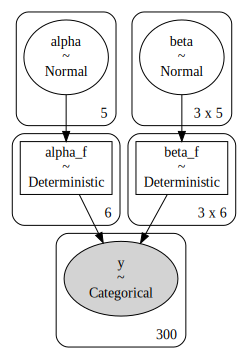

In [18]:
ret = pm.model_to_graphviz(model)
ret.render(filename=outdir + f'{DAY}_model', format='png')
ret

In [19]:
with model:
    start = pm.find_MAP(method='Powell')
    step = pm.NUTS()
    trace_sf = pm.sample(3000, step=step)

Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 134 seconds.


ValueError: ignored

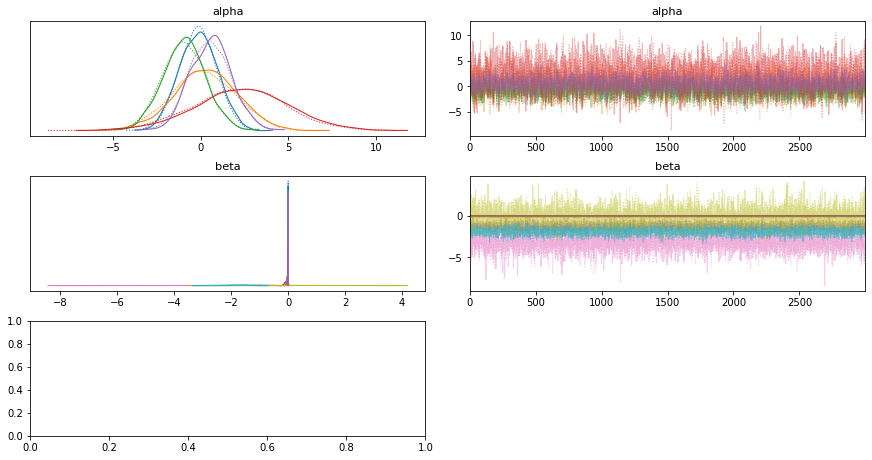

In [20]:
_ = pm.traceplot(trace_sf)

In [21]:
pm.summary(trace_sf)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.163,1.074,-2.164,1.838,0.023,0.016,2174.0,2174.0,2174.0,2951.0,1.0
alpha[1],0.208,1.815,-3.189,3.603,0.038,0.027,2270.0,2270.0,2267.0,2983.0,1.0
alpha[2],-0.971,1.215,-3.260,1.295,0.026,0.019,2110.0,2110.0,2116.0,3100.0,1.0
alpha[3],2.257,2.644,-2.787,7.220,0.052,0.037,2557.0,2557.0,2551.0,3529.0,1.0
alpha[4],0.548,1.193,-1.571,2.876,0.026,0.018,2151.0,2151.0,2153.0,3378.0,1.0
"beta[0,0]",-0.015,0.016,-0.044,0.015,0.000,0.000,3454.0,3454.0,3457.0,4009.0,1.0
"beta[0,1]",-0.047,0.029,-0.102,0.009,0.000,0.000,3867.0,3707.0,3871.0,4065.0,1.0
"beta[0,2]",-0.022,0.018,-0.056,0.011,0.000,0.000,3847.0,3761.0,3852.0,3865.0,1.0
"beta[0,3]",-0.096,0.046,-0.182,-0.012,0.001,0.001,4957.0,4054.0,5144.0,3778.0,1.0
"beta[0,4]",-0.031,0.018,-0.063,0.002,0.000,0.000,3304.0,3304.0,3292.0,4227.0,1.0
